In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/commaImages'),
 PosixPath('/home/jupyter/.fastai/data/camvid/modelFinal.pkl')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'
path_commaImages = path/'commaImages'

## Subset of classes

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_01680.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06630.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_009120.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009720_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f03930_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01110_P.png')]

In [8]:
img_f = fnames[0]; img_f

PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_01680.png')

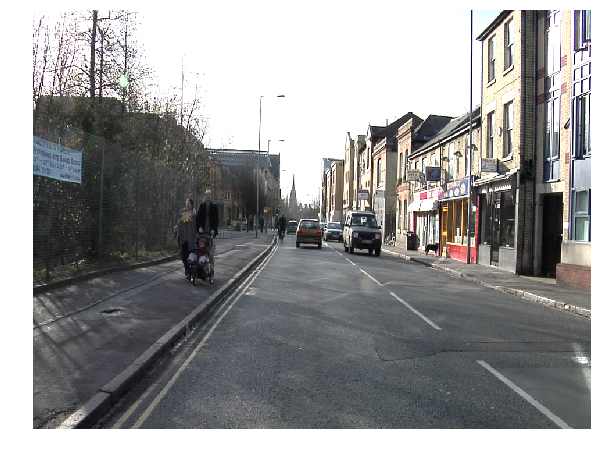

In [16]:
img = open_image(img_f)
img.show(figsize=(10,10))

In [27]:
img.shape

torch.Size([3, 720, 960])

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

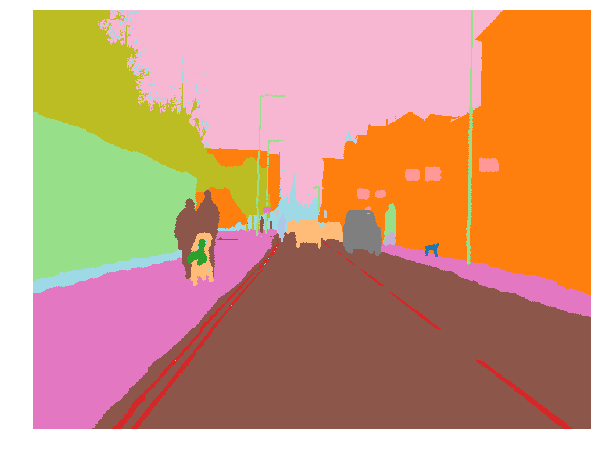

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [17]:
size = src_size // 2

free = gpu_mem_get_free_no_cache()

# the max size of bs depends on the available GPU RAM
if free > 8200:
    bs = 8
else:
    bs = 4

print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [18]:
type(src_size)

numpy.ndarray

In [20]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [21]:
type(src)

fastai.data_block.LabelLists

In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [24]:
type(data)

fastai.vision.data.ImageDataBunch

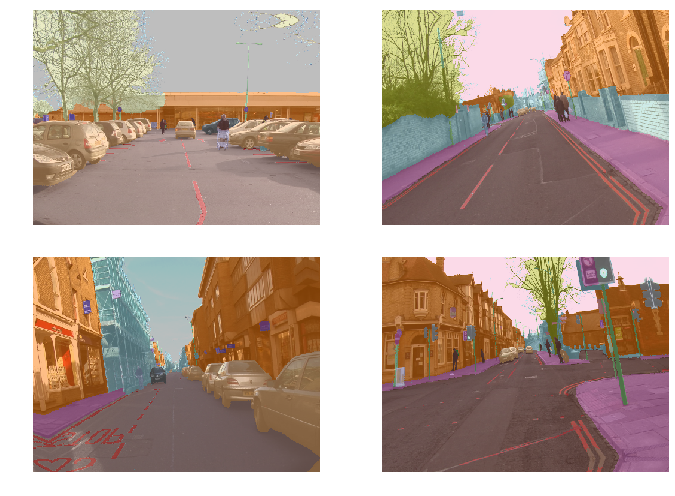

In [25]:
data.show_batch(2, figsize=(10,7))

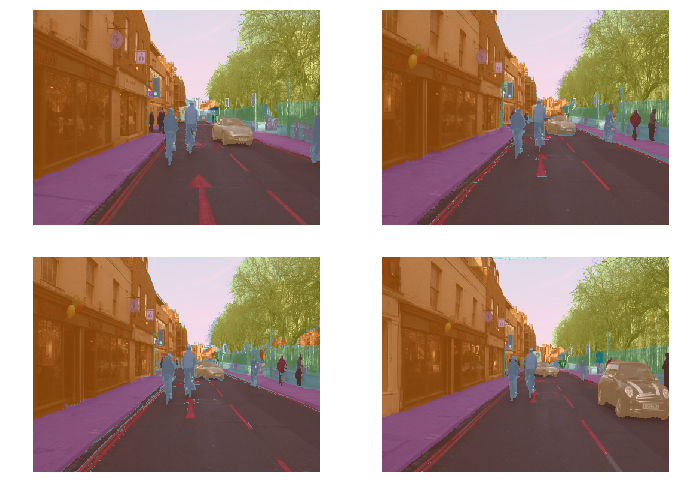

In [26]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

In [28]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [29]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [30]:
metrics = acc_camvid

In [31]:
wd = 1e-2

In [32]:
learn = unet_learner(data, models.resnet34, metrics = metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


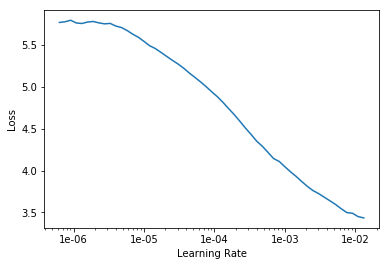

In [33]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr = 1e-2

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.268445,1.341355,0.565986,01:37
1,1.246470,1.341485,0.585381,01:38
2,1.228841,1.292578,0.604148,01:37
3,1.215181,1.372713,0.586002,01:37
4,1.206224,1.291801,0.601200,01:38
5,1.264664,1.290883,0.591089,01:38
6,1.204658,1.395052,0.580001,01:38
7,1.198955,1.290677,0.600635,01:38
8,1.153811,1.334769,0.585984,01:38
9,1.119809,1.217176,0.621477,01:38


In [38]:
learn.save('stage-1')

In [39]:
learn.load('stage-1');

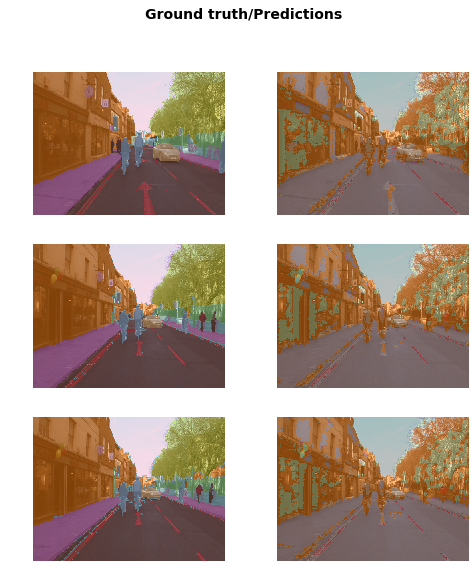

In [40]:
learn.show_results(rows=3, figsize=(8,9))

In [41]:
learn.unfreeze()

In [42]:
lrs = slice(lr/400, lr/4)

In [43]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.088256,1.217321,0.614024,01:40
1,1.067310,1.208775,0.620328,01:42
2,1.074265,1.205706,0.620080,01:43
3,1.068545,1.185882,0.629665,01:43
4,1.058773,1.190228,0.614326,01:44
5,1.034997,1.140190,0.629623,01:44
6,1.023347,1.188879,0.631093,01:44
7,1.028008,1.170335,0.644048,01:44
8,1.028545,1.058299,0.667814,01:44
9,1.024391,1.127314,0.653687,01:44


In [44]:
learn.save('stage-2');

## Go big

In [45]:
learn.destroy()
size = src_size

free = gpu_mem_get_free_no_cache()

if free > 8200:
    bs = 3

else: 
    bs =1

print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7116MB of GPU RAM free


In [46]:
data = (src.transform(get_transforms(), size = size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [49]:
learn = unet_learner(data, models.resnet34, metrics = metrics, wd=wd)

In [50]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


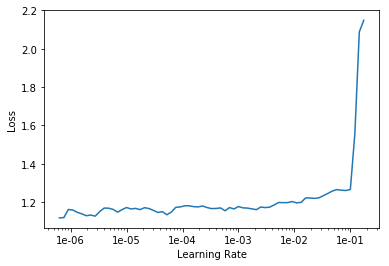

In [51]:
lr_find(learn)
learn.recorder.plot()

In [52]:
lr = 1e-3

In [53]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.139949,1.229932,0.642406,06:46
1,1.115502,1.179241,0.649567,06:54
2,1.104000,1.200628,0.650893,06:53
3,1.065193,1.138635,0.666627,06:54
4,1.089654,1.525222,0.523197,06:54
5,1.044913,1.327976,0.617276,06:54
6,1.064154,1.157004,0.656422,06:54
7,1.087638,1.129569,0.676452,06:54
8,0.967571,1.140016,0.659525,06:54
9,1.021103,1.199478,0.652870,06:55


In [54]:
learn.save('stage-1-big')

In [55]:
learn.load('stage-1-big');

In [56]:
learn.unfreeze()

In [57]:
lrs = slice(1e-6, lr/10)

In [58]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.974962,1.156639,0.668814,07:10
1,0.967856,1.163926,0.668019,07:17
2,0.959496,1.317345,0.602350,07:17
3,0.996511,1.170830,0.664415,07:18
4,0.978176,1.256442,0.622984,07:17
5,0.985486,1.211939,0.642438,07:17
6,0.977209,1.161826,0.666409,07:18
7,0.940914,1.194356,0.654119,07:17
8,1.008866,1.212908,0.643752,07:18
9,0.980847,1.311817,0.595521,07:18


In [59]:
learn.save('stage-2-big')

In [60]:
learn.load('stage-2-big');

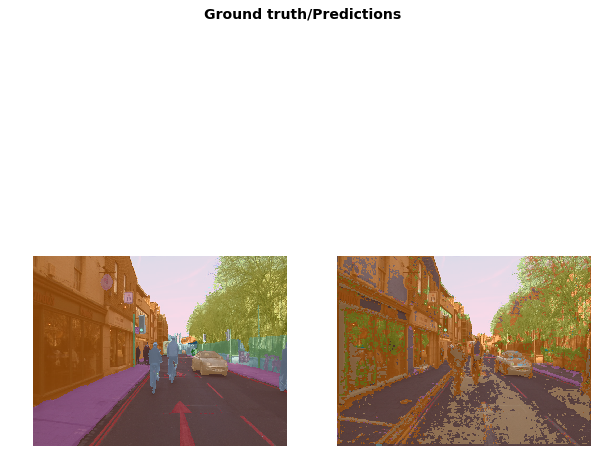

In [61]:
learn.show_results(rows=3, figsize=(10,10))